<a href="https://colab.research.google.com/github/yeesem/Time-Series-Data-Analysis/blob/main/ML_Airline_With_Differencing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!wget -nc https://lazyprogrammer.me/course_files/airline_passengers.csv

--2023-11-17 14:14:24--  https://lazyprogrammer.me/course_files/airline_passengers.csv
Resolving lazyprogrammer.me (lazyprogrammer.me)... 172.67.213.166, 104.21.23.210, 2606:4700:3031::6815:17d2, ...
Connecting to lazyprogrammer.me (lazyprogrammer.me)|172.67.213.166|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2036 (2.0K) [text/csv]
Saving to: ‘airline_passengers.csv’

airline_passengers. 100%[===================>]   1.99K  --.-KB/s    in 0s      

2023-11-17 14:14:24 (27.0 MB/s) - ‘airline_passengers.csv’ saved [2036/2036]



In [2]:
!pip install -U scikit-learn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.8/10.8 MB 82.7 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.2.2
    Uninstalling scikit-learn-1.2.2:
      Successfully uninstalled scikit-learn-1.2.2


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [4]:
!head airline_passengers.csv

"Month","Passengers"
"1949-01",112
"1949-02",118
"1949-03",132
"1949-04",129
"1949-05",121
"1949-06",135
"1949-07",148
"1949-08",148
"1949-09",136


In [5]:
df = pd.read_csv('airline_passengers.csv',index_col = 'Month',parse_dates = True)

In [6]:
df.head()

,Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


In [7]:
df['LogPassengers'] = np.log(df['Passengers'])

In [8]:
df['LogPassengersDiff'] = np.log(df['Passengers']).diff()

In [9]:
NTest = 12
train = df.iloc[:-NTest]
test = df.iloc[-NTest:]

In [10]:
#Make supervised dataset
series = df['LogPassengersDiff'].to_numpy()[1:]

T = 10
X = []
Y = []

for t in range(len(series) - T):
  x = series[t:t+T]
  X.append(x)
  y = series[t+T]
  Y.append(y)

In [11]:
XTrain,YTrain = X[:-NTest],Y[:-NTest]
XTest,YTest = X[-NTest:],Y[-NTest:]

In [12]:
from sklearn.linear_model import LinearRegression

lr = LinearRegression()
lr.fit(XTrain,YTrain)
lr.score(XTrain,YTrain)

0.6837135048453121

In [13]:
lr.score(XTest,YTest)

0.6492870172668167

In [14]:
train_idx = df.index <= train.index[-1]
test_idx = ~train_idx

#First T+1 values are not predictable
train_idx[:T+1] = False

In [15]:
#Needed to compute un-differenced predictions
df['ShiftLogPassengers'] = df['LogPassengers'].shift(1)
prev = df['ShiftLogPassengers']

In [16]:
df.head()

,Passengers,LogPassengers,LogPassengersDiff,ShiftLogPassengers
Month,,,,
1949-01-01,112,4.718499,NaN,NaN
1949-02-01,118,4.770685,0.052186,4.718499
1949-03-01,132,4.882802,0.112117,4.770685
1949-04-01,129,4.859812,-0.022990,4.882802
1949-05-01,121,4.795791,-0.064022,4.859812


In [17]:
last_train = train.iloc[-1]['LogPassengers']
print(last_train)
print(train.tail(1))

6.003887067106539
            Passengers  LogPassengers  LogPassengersDiff
Month                                                   
1959-12-01         405       6.003887           0.112243


In [18]:
#1-step forecast
df.loc[train_idx,'LR_1step_train'] = prev[train_idx] + lr.predict(XTrain)
df.loc[test_idx,'LR_1step_test'] = prev[test_idx] + lr.predict(XTest)

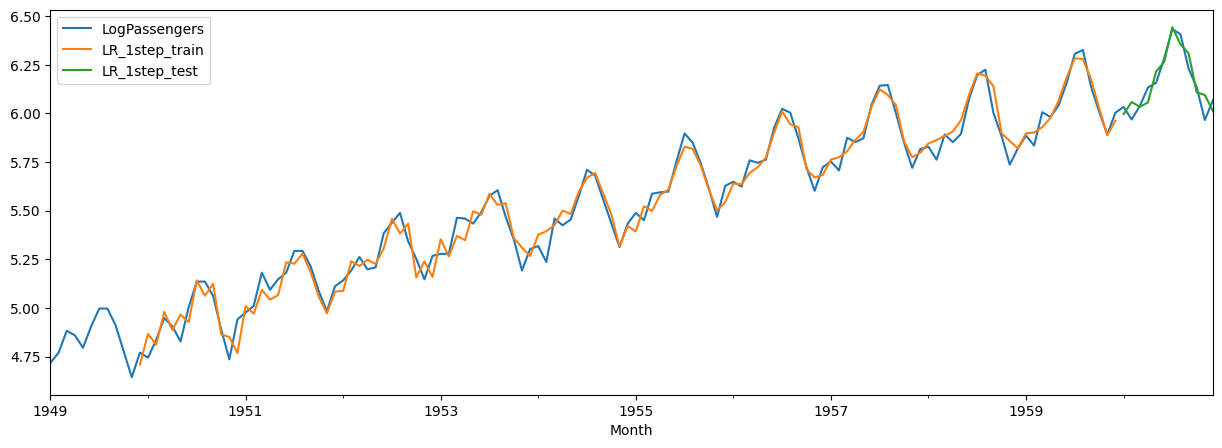

In [19]:
col = [
    "LogPassengers",
    "LR_1step_train",
    "LR_1step_test"
]
df[col].plot(figsize = (15,5));

In [20]:
#multi step forecast
multistep_predictions = []

#first test input
last_x = XTest[0]

while len(multistep_predictions) < NTest:
  p = lr.predict(last_x.reshape(1,-1))[0]

  #Update the predictions list
  multistep_predictions.append(p)

  last_x = np.roll(last_x,-1)
  last_x[-1] = p

In [21]:
#Save multi_step forecast to dataframe
df.loc[test_idx,'LR_multistep'] = last_train + np.cumsum(multistep_predictions)

<Axes: xlabel='Month'>

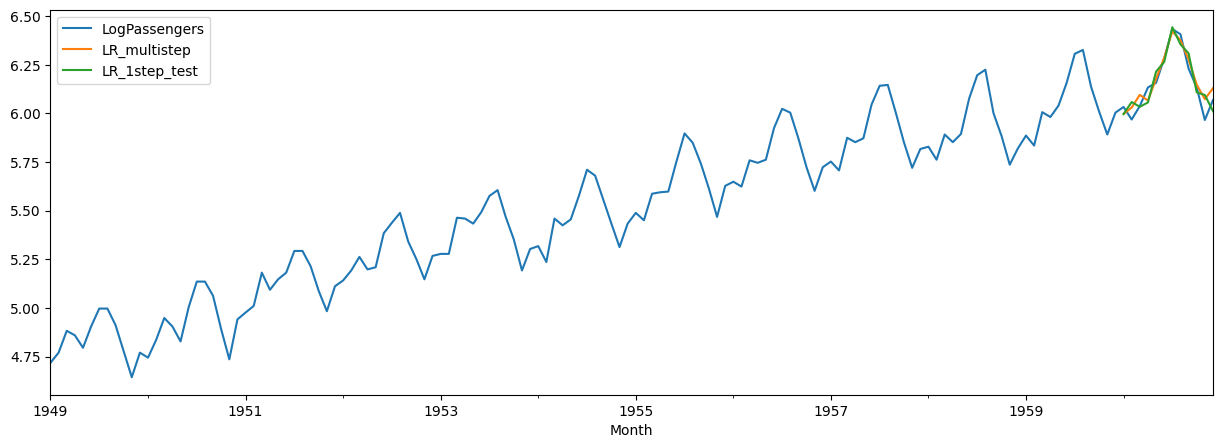

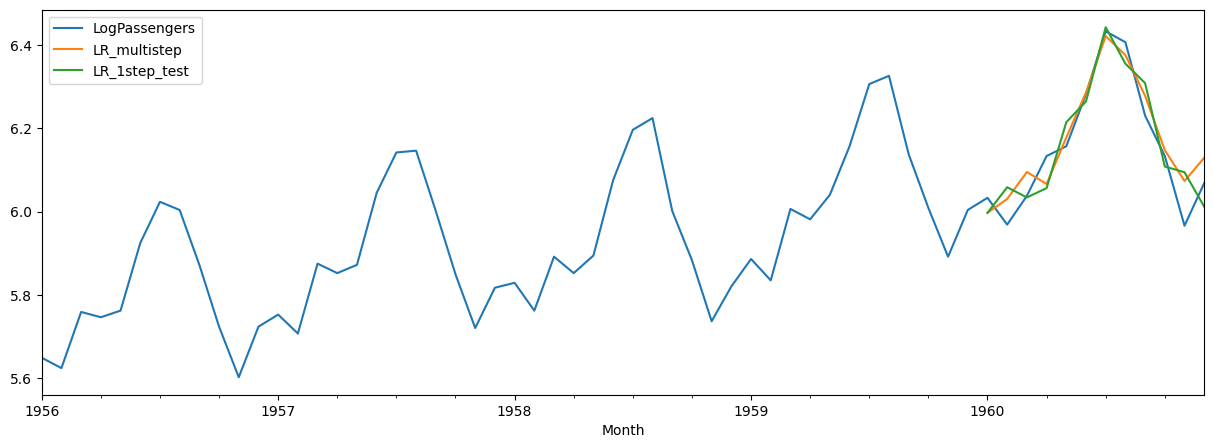

In [22]:
#Plot 1-step and multi-step forecast
col = [
    "LogPassengers",
    "LR_multistep",
    "LR_1step_test"
]
df[col].plot(figsize = (15,5))
df.iloc[-60:][col].plot(figsize = (15,5))

In [28]:
#Make multi-output supervised dataset
#series = LogPassengerDiff
Tx = T
Ty = NTest
X = []
Y = []

for t in range(len(series) - Tx - Ty + 1):
  x = series[t : t+Tx]
  X.append(x)
  y = series[t + Tx: t+Tx+Ty]
  Y.append(y)

In [31]:
X = np.array(X).reshape(-1,Tx)
Y = np.array(Y).reshape(-1,Ty)
N = len(X)
print("X shape: ",X.shape," Y shape: ",y.shape)

X shape:  (122, 10)  Y shape:  (12,)


In [35]:
XTrain_m,YTrain_m = X[:-1],Y[:-1]
XTest_m,YTest_m = X[-1:],Y[-1:]

In [40]:
lr = LinearRegression()
lr.fit(XTrain_m,YTrain_m)
lr.score(XTrain_m,YTrain_m)

0.8141637147930584

In [46]:
from sklearn.metrics import r2_score
r2_score(lr.predict(XTest_m).flatten(),YTest_m.flatten())

0.7690077978619653

In [47]:
#Save multi output forecast to dataframe
#cumsum - culmulative sum
df.loc[test_idx,'LR_multioutput'] = last_train + \
np.cumsum(lr.predict(XTest_m).flatten())

<Axes: xlabel='Month'>

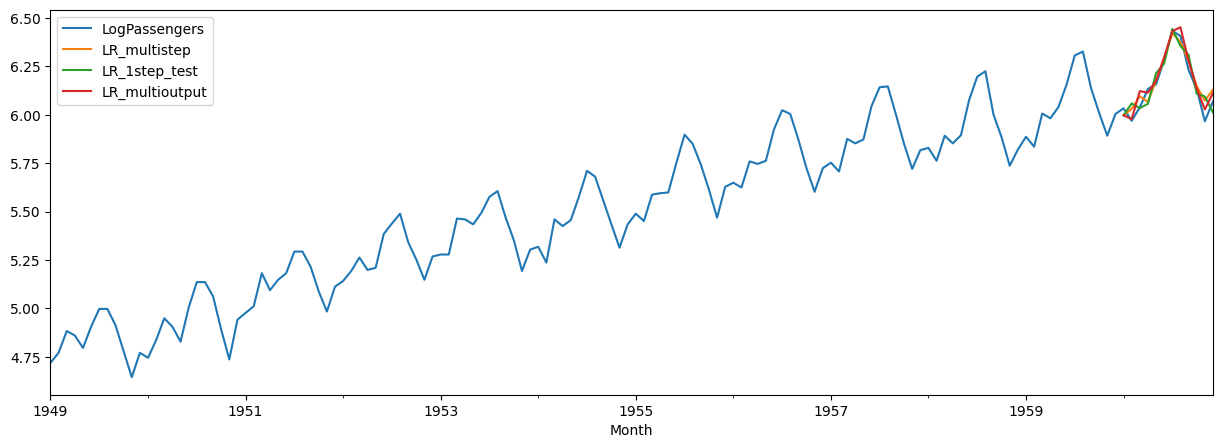

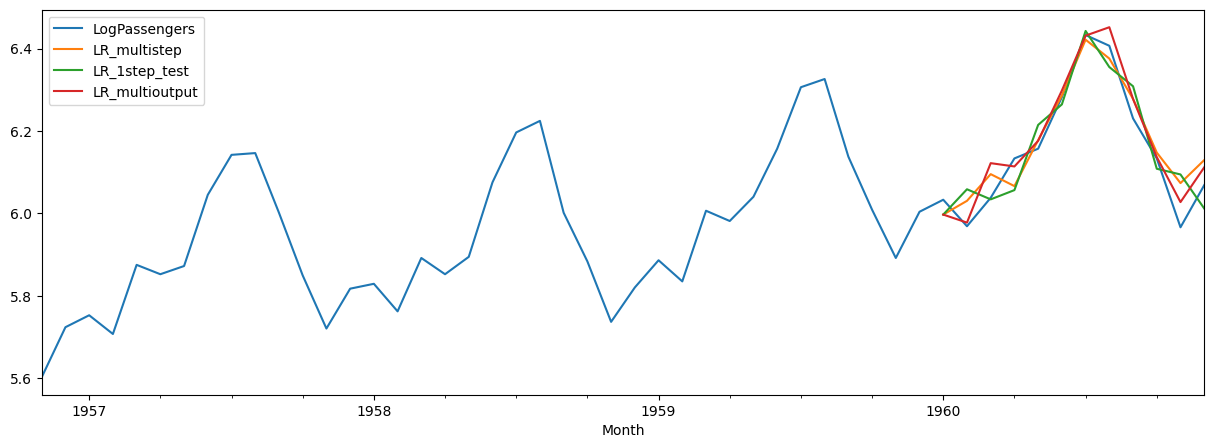

In [51]:
cols = ['LogPassengers','LR_multistep','LR_1step_test','LR_multioutput']
df[cols].plot(figsize = (15,5));
df.iloc[-50:][cols].plot(figsize = (15,5))

In [53]:
#MAPE
from sklearn.metrics import mean_absolute_percentage_error
test_log_pass = df.iloc[-NTest:]['LogPassengers']
mape1 = mean_absolute_percentage_error(
    test_log_pass,df.loc[test_idx,'LR_multistep']
)
print("multi-step mape : " , mape1)
mape2 = mean_absolute_percentage_error(
    test_log_pass,df.loc[test_idx,'LR_multioutput']
)
print("multi-output mape : ",mape2)

multi-step mape :  0.007109281288502536
multi-output mape :  0.005245261617574879


In [61]:
def one_step_and_multistep_forecast(model,name):
  model.fit(XTrain,YTrain)
  print("One-step forecast : ",name)
  print("Train R^2: ", model.score(XTrain,YTrain))
  print("Test  R^2: ", model.score(XTest,YTest))

  #Store 1-step forecast
  df.loc[train_idx,f"{name}_1step_train"] = \
  prev[train_idx] + model.predict(XTrain)
  df.loc[test_idx,f"{name}_1step_test"] = \
  prev[test_idx] + model.predict(XTest)

  #Generate multistep forecast
  multistep_predictions = []

  last_x = XTest[0]

  while len(multistep_predictions) < NTest:
    p = model.predict(last_x.reshape(1,-1))[0]

    #Update the prediction list
    multistep_predictions.append(p)

    #Make the new input
    last_x = np.roll(last_x,-1)
    last_x[-1] = p

  #Store multistep forecast
  df.loc[test_idx,f"{name}_multistep_test"] = \
  last_train + np.cumsum(multistep_predictions)

  #MAPE of multi-step forecast
  test_log_pass = df.iloc[-NTest:]['LogPassengers']
  mape = mean_absolute_percentage_error(
      test_log_pass,df.loc[test_idx,f'{name}_multistep_test']
  )
  print('Test MAPE (multi-step): ',mape)

  #Plot 1-step and multi-step forecast
  cols = [
      'LogPassengers',
      f"{name}_1step_train",
      f"{name}_1step_test",
      f"{name}_multistep_test"
  ]

  df[cols].plot(figsize = (15,5))
  df.iloc[-30:][cols].plot(figsize = (15,5));


One-step forecast :  SVR
Train R^2:  0.6594291471853797
Test  R^2:  0.505294764564929
Test MAPE (multi-step):  0.012149122102392764


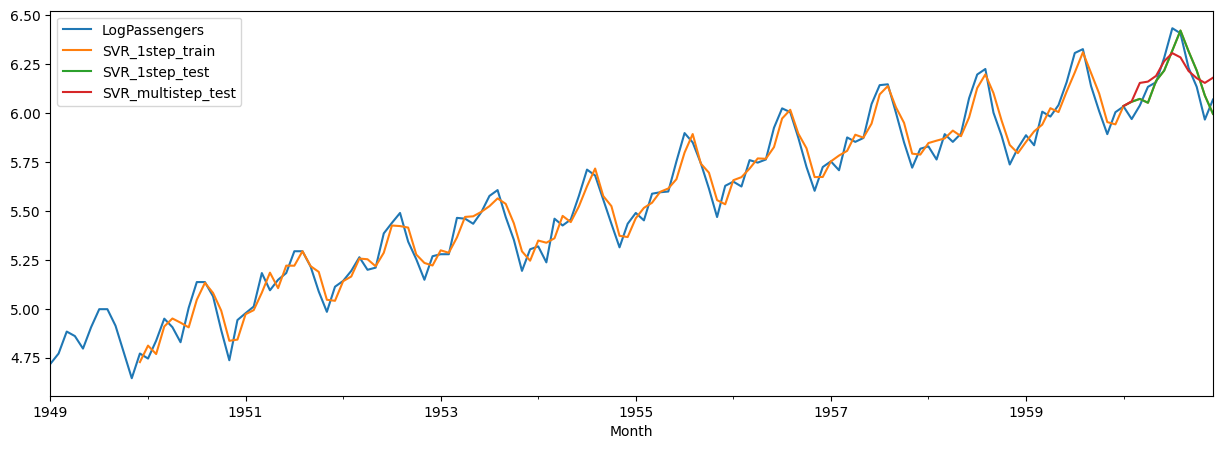

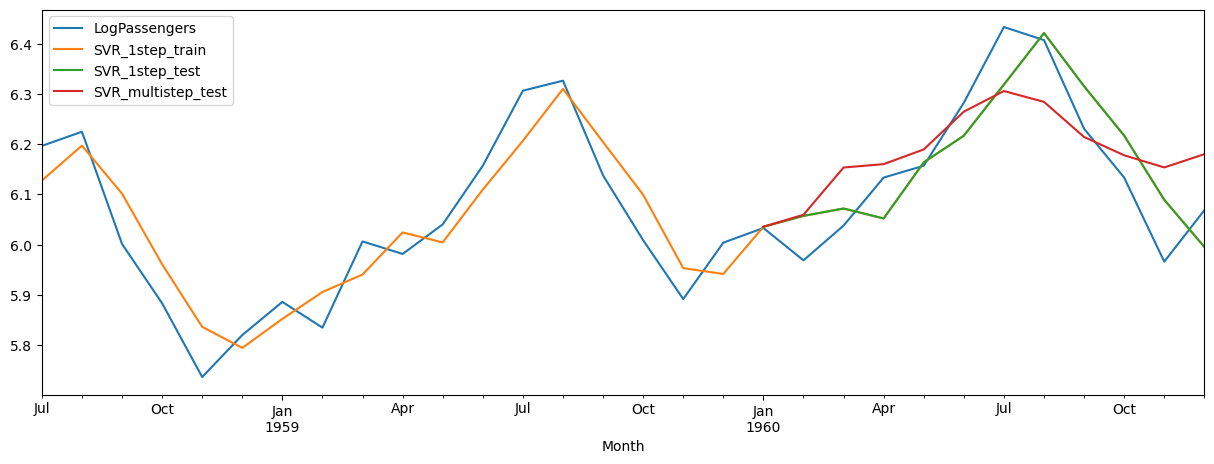

In [62]:
from sklearn.svm import SVR
one_step_and_multistep_forecast(SVR(),"SVR")

One-step forecast :  RF
Train R^2:  0.9665468387101555
Test  R^2:  0.707011385435387
Test MAPE (multi-step):  0.005823610080289142


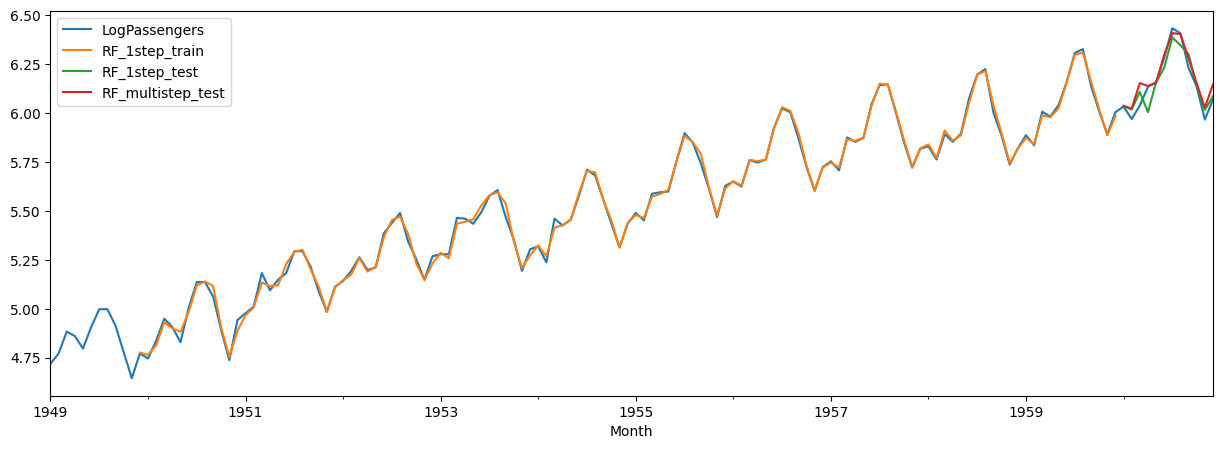

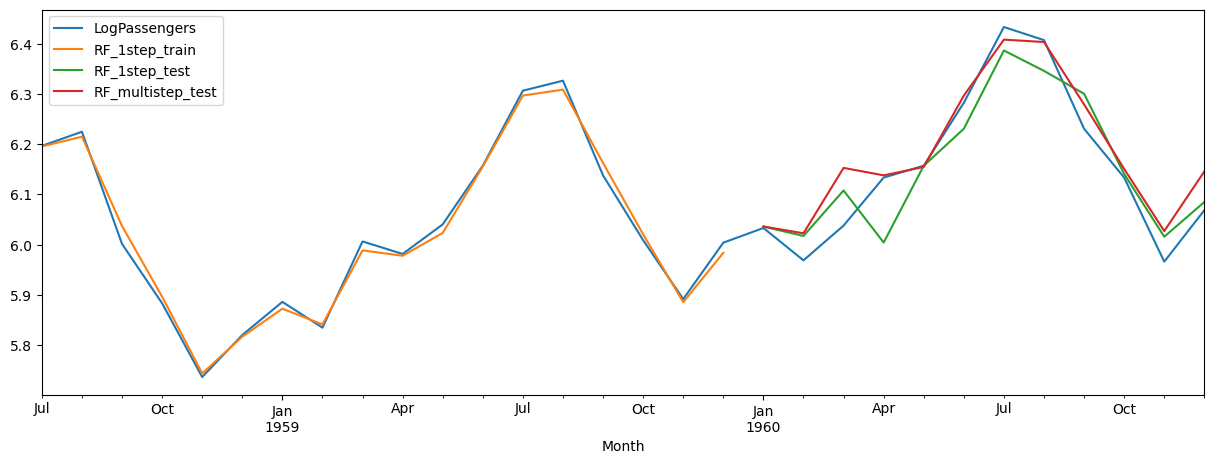

In [67]:
from sklearn.ensemble._forest import RandomForestRegressor
one_step_and_multistep_forecast(RandomForestRegressor(),'RF')